In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col

# Initialize Spark
spark = SparkSession.builder.appName("PersonalizedLearning").getOrCreate()

# Load the dataset
data = spark.read.csv("student_performance.csv", header=True, inferSchema=True)

# Print schema of the DataFrame
data.printSchema()

# Show basic statistics of the DataFrame
data.describe().show()

# Count null values in each column and show the result
null_counts = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
null_counts.show()


root
 |-- student_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- study_time: string (nullable = true)
 |-- G1: integer (nullable = true)
 |-- G2: integer (nullable = true)
 |-- G3: integer (nullable = true)

+-------+----------+------+----------+-----------------+-----------------+-----------------+
|summary|student_id|gender|study_time|               G1|               G2|               G3|
+-------+----------+------+----------+-----------------+-----------------+-----------------+
|  count|       500|   500|       500|              500|              500|              500|
|   mean|      NULL|  NULL|      NULL|             9.65|           10.064|             9.66|
| stddev|      NULL|  NULL|      NULL|6.199060954162883|5.976566128252137|5.941295986229936|
|    min| STUDENT_1|     F| 2-5 hours|                0|                0|                0|
|    max|STUDENT_99|     M| >10 hours|               20|               20|               20|
+-------+----------+---

In [ ]:
data = data.na.fill({'G1': 0, 'G2': 0, 'G3': 0})  # Example of filling missing grades with 0


In [ ]:
from pyspark.sql.functions import col

data = data.withColumn("average_grade", (col("G1") + col("G2") + col("G3")) / 3)


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
data = indexer.fit(data).transform(data)

encoder = OneHotEncoder(inputCols=["gender_index"], outputCols=["gender_ohe"])
data = encoder.fit(data).transform(data)


In [ ]:
feature_columns = ["average_grade", "study_time", "gender_ohe"]


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans

# Initialize Spark
spark = SparkSession.builder.appName("PersonalizedLearning").getOrCreate()

# Load the dataset
data = spark.read.csv("student_performance.csv", header=True, inferSchema=True)

# Show the schema to understand data types
data.printSchema()

# Convert 'study_time' to a numeric format using StringIndexer
indexer = StringIndexer(inputCol="study_time", outputCol="study_time_indexed")
data_indexed = indexer.fit(data).transform(data)

# Select feature columns (ensure these are numeric)
feature_columns = ["study_time_indexed", "G1", "G2", "G3"]  # Modify this based on your dataset

# Assemble features for KMeans
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_kmeans = assembler.transform(data_indexed)

# Apply KMeans clustering
kmeans = KMeans(k=3, seed=1)  # Assuming 3 clusters
model = kmeans.fit(data_kmeans)

# Make predictions
predictions = model.transform(data_kmeans)

# Show the results
predictions.select("student_id", "study_time", "features", "prediction").show()

root
 |-- student_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- study_time: string (nullable = true)
 |-- G1: integer (nullable = true)
 |-- G2: integer (nullable = true)
 |-- G3: integer (nullable = true)

+----------+----------+--------------------+----------+
|student_id|study_time|            features|prediction|
+----------+----------+--------------------+----------+
| STUDENT_1|5-10 hours|[3.0,16.0,18.0,10.0]|         2|
| STUDENT_2|  <2 hours|  [0.0,8.0,0.0,12.0]|         1|
| STUDENT_3|  <2 hours|      (4,[2],[14.0])|         1|
| STUDENT_4| >10 hours|  [1.0,20.0,7.0,5.0]|         0|
| STUDENT_5|5-10 hours|  [3.0,19.0,1.0,8.0]|         0|
| STUDENT_6|  <2 hours|  [0.0,12.0,2.0,7.0]|         0|
| STUDENT_7| >10 hours|[1.0,15.0,13.0,10.0]|         0|
| STUDENT_8|5-10 hours|[3.0,12.0,13.0,18.0]|         2|
| STUDENT_9| >10 hours| [1.0,13.0,10.0,8.0]|         0|
|STUDENT_10| 2-5 hours| [2.0,2.0,15.0,16.0]|         2|
|STUDENT_11|  <2 hours|  [0.0,5.0,3.0,1

In [ ]:
# Function to recommend resources based on the cluster
def recommend_resources(cluster):
    resources = {
        0: ["Basic Algebra Book", "Introductory Algebra Video"],
        1: ["Advanced Calculus Book", "Calculus Quiz"],
        2: ["Statistics Course", "Data Analysis Video"]
    }
    return resources.get(cluster, [])

# Create a DataFrame for recommendations
recommendations = predictions.rdd.map(lambda row: (row.student_id, recommend_resources(int(row.prediction)))).toDF(["student_id", "recommended_resources"])

# Show recommendations
recommendations.show(truncate=False)

# Stop the Spark session
spark.stop()


+----------+------------------------------------------------+
|student_id|recommended_resources                           |
+----------+------------------------------------------------+
|STUDENT_1 |[Statistics Course, Data Analysis Video]        |
|STUDENT_2 |[Advanced Calculus Book, Calculus Quiz]         |
|STUDENT_3 |[Advanced Calculus Book, Calculus Quiz]         |
|STUDENT_4 |[Basic Algebra Book, Introductory Algebra Video]|
|STUDENT_5 |[Basic Algebra Book, Introductory Algebra Video]|
|STUDENT_6 |[Basic Algebra Book, Introductory Algebra Video]|
|STUDENT_7 |[Basic Algebra Book, Introductory Algebra Video]|
|STUDENT_8 |[Statistics Course, Data Analysis Video]        |
|STUDENT_9 |[Basic Algebra Book, Introductory Algebra Video]|
|STUDENT_10|[Statistics Course, Data Analysis Video]        |
|STUDENT_11|[Advanced Calculus Book, Calculus Quiz]         |
|STUDENT_12|[Statistics Course, Data Analysis Video]        |
|STUDENT_13|[Basic Algebra Book, Introductory Algebra Video]|
|STUDENT

In [ ]:
predictions_pandas = predictions.select("study_time", "G1", "G2", "G3", "prediction").toPandas()


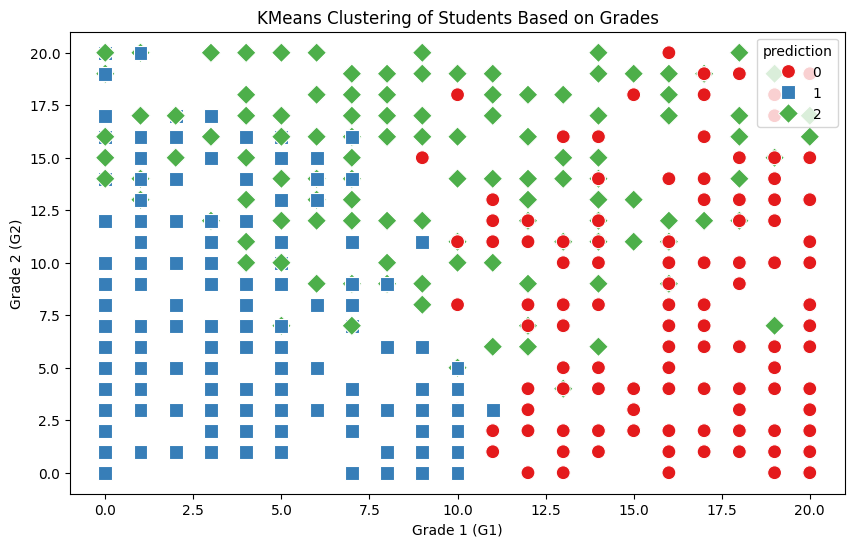

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the cluster plot with different shapes
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='G1', y='G2',                # We can also try 'G3' or 'study_time'
    hue='prediction',              # Color by cluster prediction
    style='prediction',            # Use different shapes for each cluster
    data=predictions_pandas,       # Data from KMeans predictions
    palette='Set1',                # Color palette
    markers=["o", "s", "D"],       # Circle, square, and diamond for clusters
    s=100,                         # Marker size
    legend='full'
)

# Add labels and show the plot
plt.title("KMeans Clustering of Students Based on Grades")
plt.xlabel("Grade 1 (G1)")
plt.ylabel("Grade 2 (G2)")
plt.show()
